In [120]:
import gymnasium as gym
import gym_trading_env
import yfinance as yf
from pprint import pprint
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, A2C, DDPG
import pandas as pd
from preprocessors import FeatureEngineer
from yahoodownloader import YahooDownloader
import numpy as np
%matplotlib inline

In [121]:
stock_name = "NFLX"
start_date_train = "2010-01-01"
end_date_train = "2023-01-01"
start_date_test = "2023-01-01"
end_date_test = "2023-11-01"

timesteps = 1e5

In [122]:
def get_data(stock_name, start_date, end_date):
    df = yf.download(stock_name, start=start_date, end=end_date)
    df = df.reset_index()
    df.columns = [x.lower() for x in df.columns]
    df = df.dropna()
    return df

In [123]:
df_train = YahooDownloader(start_date=start_date_train,
                     end_date = end_date_train,
                     ticker_list = [stock_name]).fetch_data()
df_test = YahooDownloader(start_date=start_date_test,
                        end_date = end_date_test,
                        ticker_list = [stock_name]).fetch_data()

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (3272, 8)
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (209, 8)


In [124]:
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30',
            'close_30_sma',
            'close_60_sma',
            'close_30_ema',
            'close_60_ema',
            'close_180_ema',
            'boll',
            'boll_ub',
            'boll_lb']


In [125]:
def add_indicators(df):
    fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = False)
    processed = fe.preprocess_data(df)
    processed = processed.copy()
    processed = processed.fillna(0)
    processed = processed.replace(np.inf,0)
    return processed

In [126]:
df_train = add_indicators(df_train)
df_test = add_indicators(df_test)

Successfully added technical indicators
Successfully added technical indicators


In [127]:
env_train = gym.make('TradingEnv', df=df_train)
env_test = gym.make('TradingEnv', df=df_test)

In [128]:
def simulate(env,models = None):
    observation, info = env.reset()
    truncated, done = False, False
    history = []
    while not done:
        action = None
        if models:
            action = 0
            if(type(models) != list):
                models = [models]
            for model in models:
                action += model.predict(observation)[0]
            action /= len(models)
            action = int(action)
        else:
            action = env.action_space.sample()
        observation, reward, done, truncated, info = env.step(action)
        if truncated:
            break
        history.append(info)
    return history

In [129]:
def plot_history(history):
    df = pd.DataFrame(history)
    actions = df['real_position']
    valuation = df['portfolio_valuation']
    dates = df['date']
    fig, ax1 = plt.subplots(figsize=(15, 8))
    ax1.plot(dates, valuation)
    ax1.scatter(dates, valuation, c=actions)
    ax1.set_xlabel('date')
    ax1.set_ylabel('valuation')
    fig.tight_layout()
    plt.show()

Market Return : 3759.69%   |   Portfolio Return : 816.26%   |   


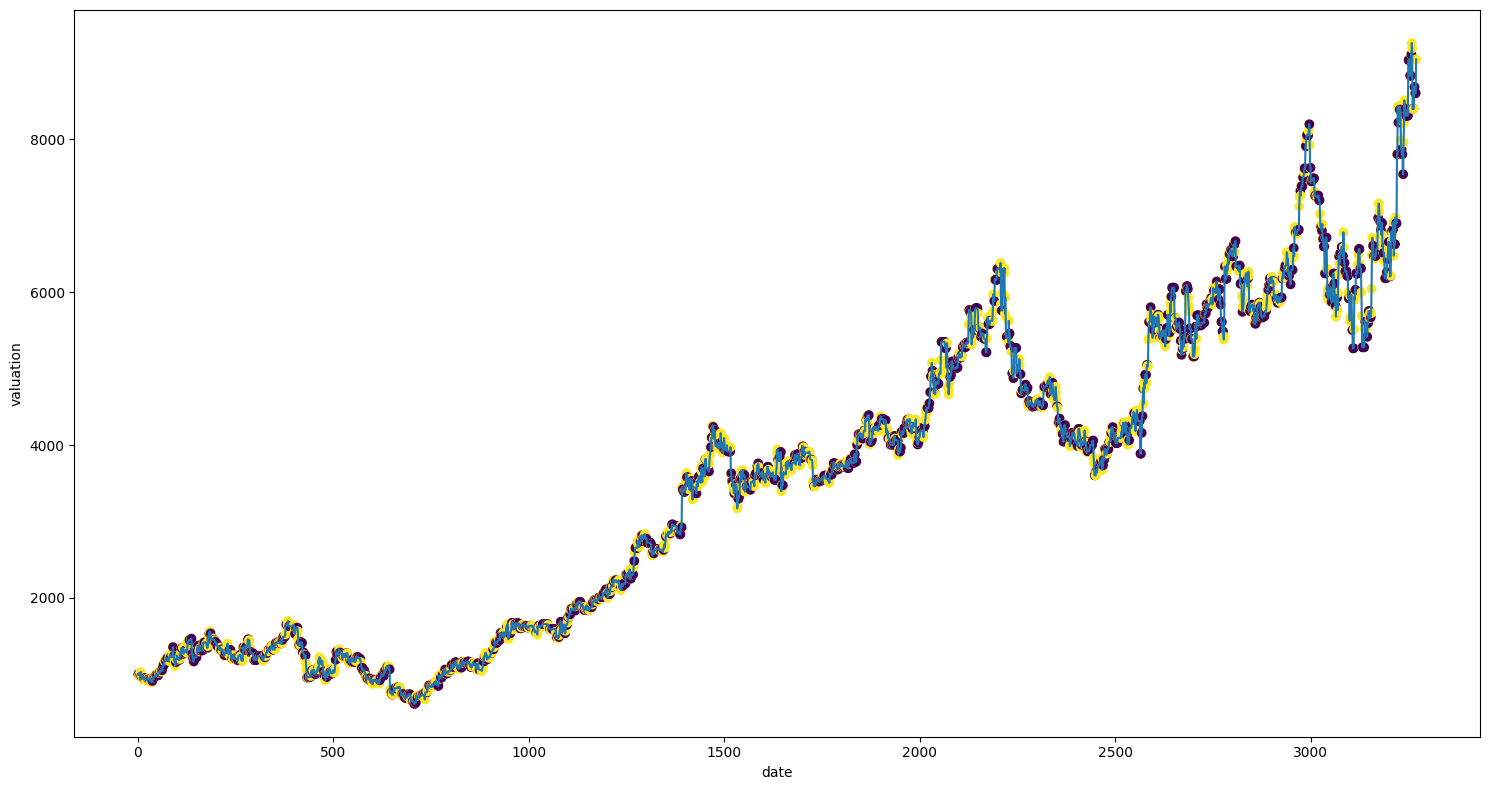

In [130]:
history = simulate(env_train)
plot_history(history)

In [131]:
model = PPO('MlpPolicy', env_train, verbose=1)
model.learn(total_timesteps=timesteps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2535 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
Market Return : 3759.69%   |   Portfolio Return : 253.42%   |   
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.27e+03    |
|    ep_rew_mean          | 1.26        |
| time/                   |             |
|    fps                  | 1869        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009257469 |
|    clip_fraction        | 0.0151      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      |
|    explained_variance   | -0.0133     |
|

Market Return : 3759.69%   |   Portfolio Return : 3759.69%   |   


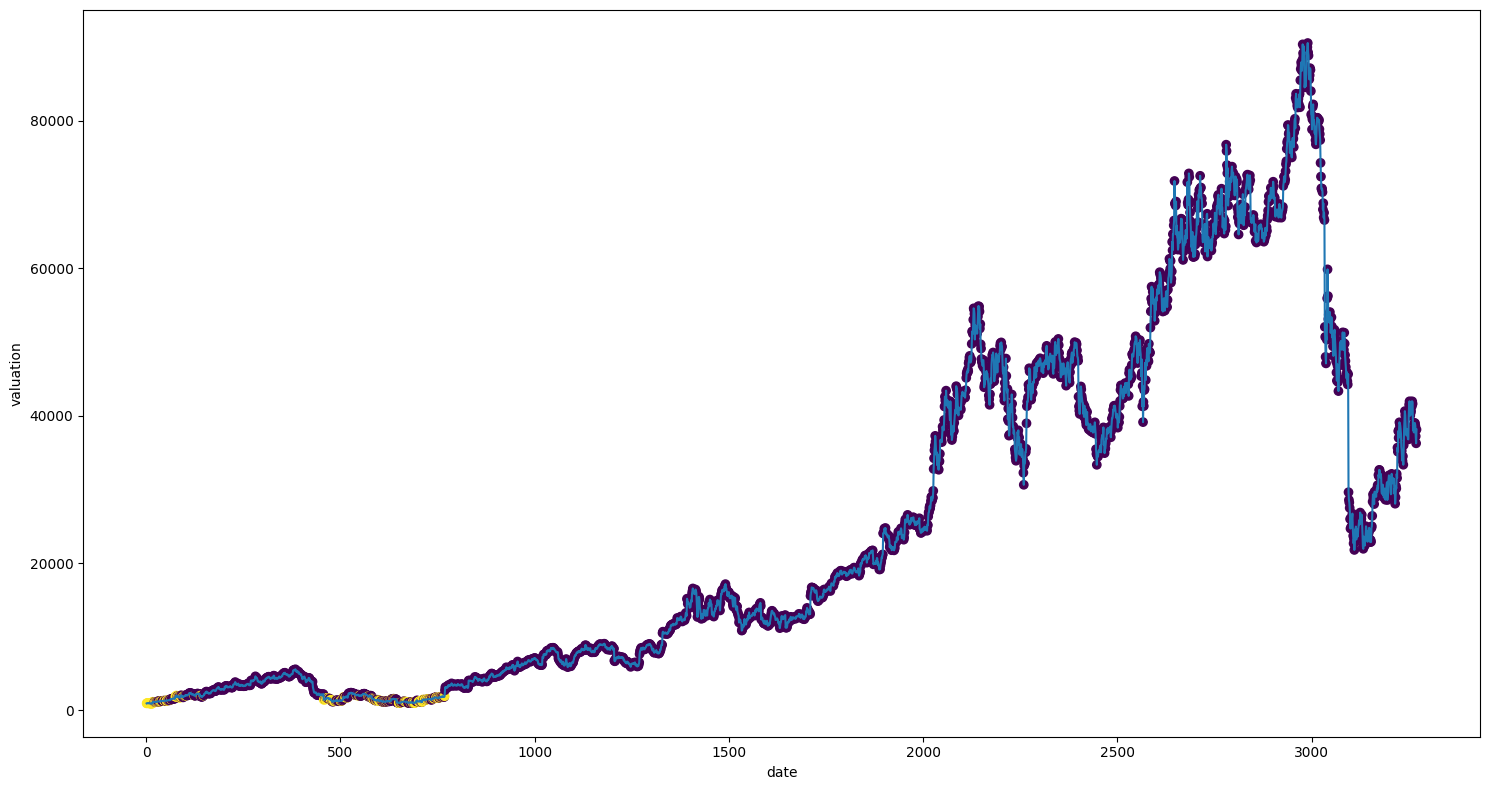

In [ ]:
history = simulate(env_train, model)
plot_history(history)

Market Return : 39.58%   |   Portfolio Return : 39.58%   |   


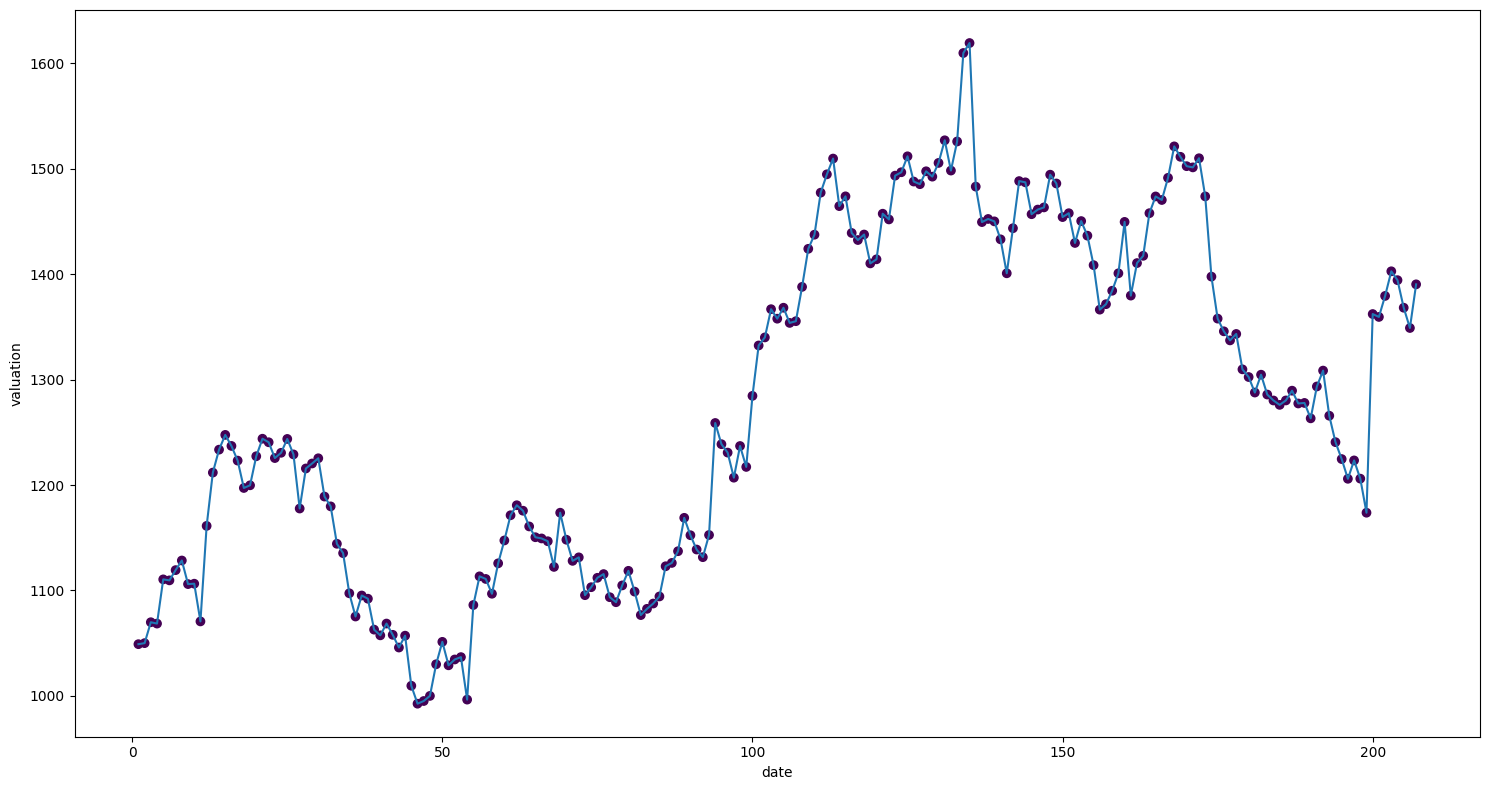

In [ ]:
history = simulate(env_test, model)
plot_history(history)

In [ ]:
a2c_model = A2C('MlpPolicy', env_train, verbose=1)
ppo_model = PPO('MlpPolicy', env_train, verbose=1)
# ddpg_model = DDPG('MlpPolicy', env, verbose=1)

models = [a2c_model, ppo_model]
for model in models:
    model.learn(total_timesteps=timesteps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/                 |          |
|    fps                | 1251     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.687   |
|    explained_variance | -4.24    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.0147  |
|    value_loss         | 0.00137  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1298     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.682   

Market Return : 3759.69%   |   Portfolio Return : 2464.91%   |   


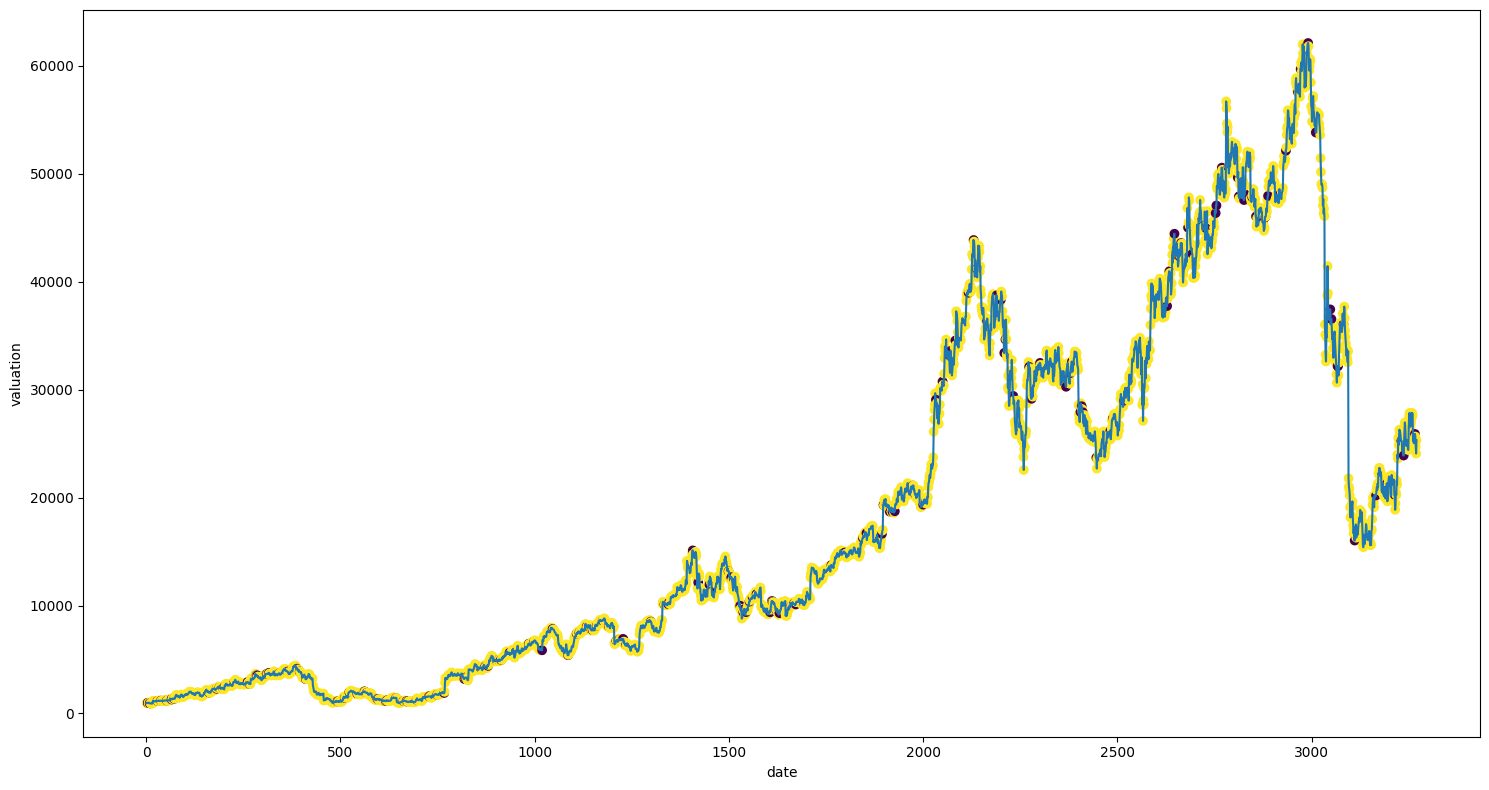

In [ ]:
history = simulate(env_train, models)
plot_history(history)

Market Return : 39.58%   |   Portfolio Return : 15.19%   |   


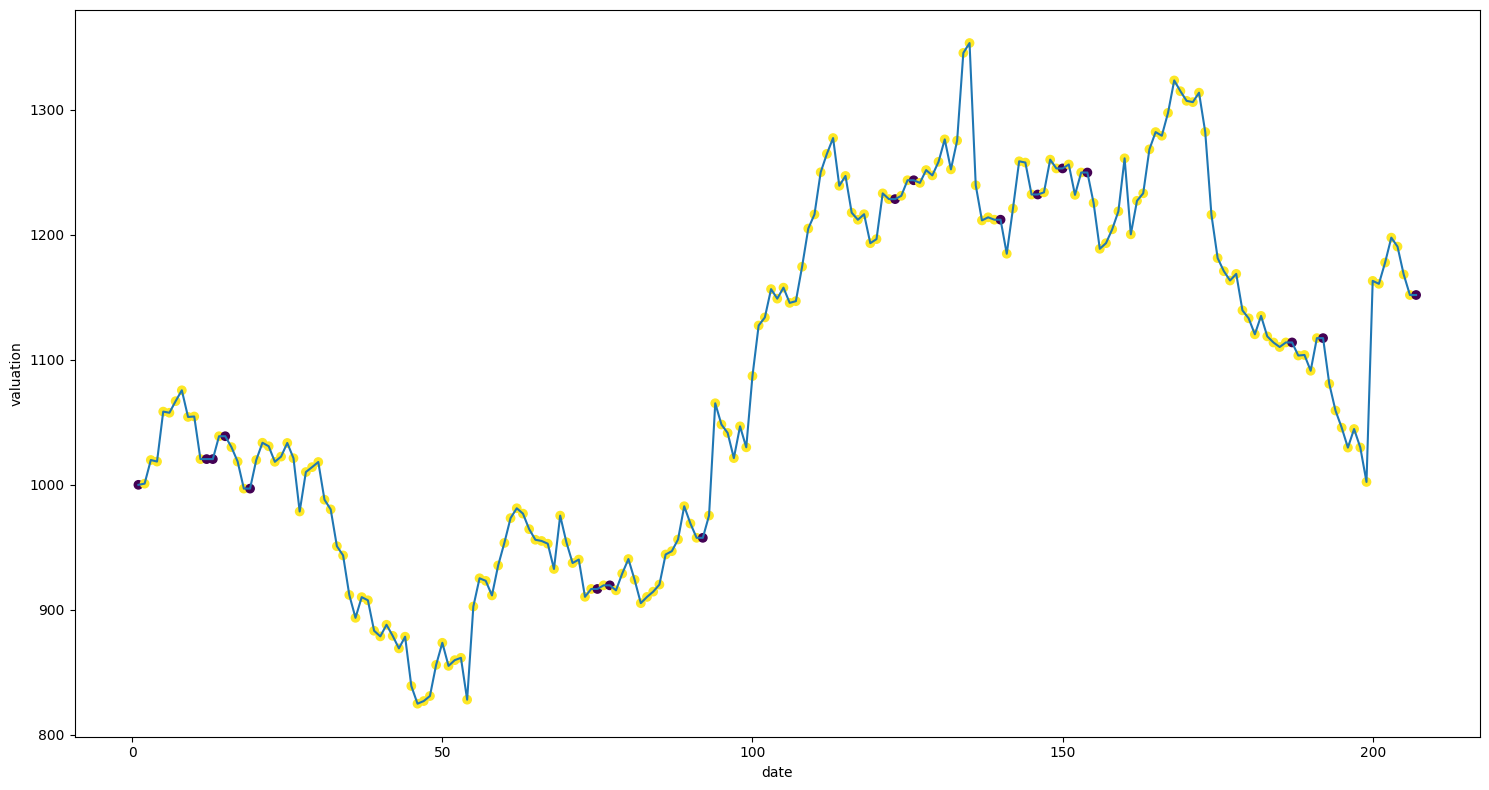

In [ ]:
history = simulate(env_test, models)
plot_history(history)